In [41]:
import numpy as np
import mne
import matplotlib
%matplotlib inline
#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import scipy
import pickle
import networkx as nx
import preprocessing as prep
from itertools import permutations
import pandas as pd
from tqdm import tqdm

from epoch_connectivity import ConnEEG as cnegg
from epoch_connectivity import ConnectionMatrices as cm
from epoch_connectivity import Connectomes as cntms

from epoch_connectivity.utils import FrequencyBand, only_EEG_channels

import mne_connectivity as mnecon

In [80]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('no_thresh_08042022.csv', index_col=0) # Read the features dataframe
full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values

#
full_df.loc[full_df["response"] == "RP", "response"] = "R"
full_df.loc[full_df["response"] == "PR", "response"] = "R"
#full_df.loc[full_df["response"] == "R", "response"] = "R"
#full_df.loc[full_df["response"] == "NR", "response"] = "0"

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'DTF_delta_SLEEP_AVGBC'),
  Text(1, 0, 'DTF_theta_SLEEP_AVGBC'),
  Text(2, 0, 'DTF_alpha_SLEEP_AVGBC'),
  Text(3, 0, 'DTF_beta_SLEEP_AVGBC'),
  Text(4, 0, 'DTF_broadband_SLEEP_AVGBC'),
  Text(5, 0, 'PDC_delta_SLEEP_AVGBC'),
  Text(6, 0, 'PDC_theta_SLEEP_AVGBC'),
  Text(7, 0, 'PDC_alpha_SLEEP_AVGBC'),
  Text(8, 0, 'PDC_beta_SLEEP_AVGBC'),
  Text(9, 0, 'PDC_broadband_SLEEP_AVGBC')])

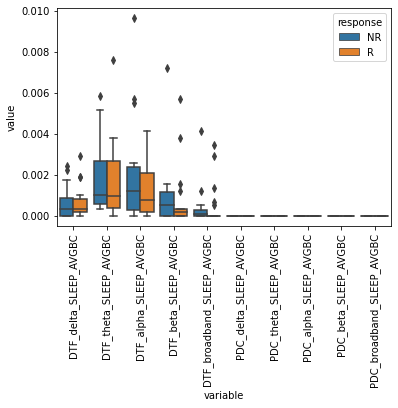

In [98]:
#aux = full_df.filter(regex='(?=.*SLEEP_MEAN_SYNCH$)|(?=.*response)',axis=1)
aux = full_df.filter(regex='(?=.*SLEEP_AVGBC$)|(?=.*response)',axis=1)

#sns.boxplot(x="response", y="wPLI_theta_SLEEP_MEAN_SYNCH", hue="response", data=aux)
sns.boxplot(x="variable", y="value", hue="response", data=pd.melt(aux, id_vars='response'))
plt.xticks(rotation=90)

#pd.melt(aux, id_vars='response')

<AxesSubplot:xlabel='response', ylabel='wPLI_alpha_SLEEP_MEAN_SYNCH'>

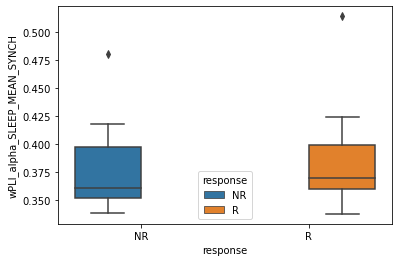

In [75]:
sns.boxplot(x="response", y="wPLI_alpha_SLEEP_MEAN_SYNCH", hue="response", data=aux)

In [35]:
pd.melt(aux, id_vars='response')

,response,variable,value
0,NR,wPLI_delta_AWAKE_MEAN_SYNCH,0.374143
1,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.353198
2,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.390946
3,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.384421
4,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.396470
...,...,...,...
125,NR,wPLI_broadband_AWAKE_MEAN_SYNCH,0.398500
126,RP,wPLI_broadband_AWAKE_MEAN_SYNCH,0.346520
127,R,wPLI_broadband_AWAKE_MEAN_SYNCH,0.397728
128,R,wPLI_broadband_AWAKE_MEAN_SYNCH,0.337260
